In [1]:
#!pip install torch torchvision torchaudio

In [2]:
# install requirements for TabSyn
#!wget https://raw.githubusercontent.com/amazon-science/tabsyn/main/requirements.txt
#!pip install -r requirements.txt

In [5]:
# download transactions
# !wget https://storage.yandexcloud.net/ds-ods/files/data/docs/competitions/DataFusion2024/Data/transactions.csv.zip
# !unzip transactions.csv.zip
# !rm transactions.csv.zip

In [6]:
!head transactions.csv

"user_id","mcc_code","currency_rk","transaction_amt","transaction_dttm"
3,3,1,-183.88395690918,2022-01-28 12:05:33
3,3,1,-3206.43701171875,2022-01-28 12:52:30
3,16,1,-153866.890625,2022-02-16 14:45:56
3,56,1,-15144.6015625,2022-03-09 19:58:29
3,0,1,5297.90869140625,2022-03-12 18:11:31
3,0,1,534.363098144531,2022-04-11 20:48:26
3,0,1,4549.455078125,2022-04-11 20:53:35
3,0,1,37991.9296875,2022-04-29 18:42:58
3,0,1,28335.61328125,2022-05-05 20:32:38


In [33]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
TIME_FORMAT='%Y-%m-%d %H:%M:%S'

In [39]:
import argparse
parser = argparse.ArgumentParser(prog='process',
                                 description='Preprocess transactions data')
parser.add_argument('--time_quantile', type=float, help='All transactions that fall into that proportion of time go into train split')
parser.add_argument('--user_quantile', type=float, help='All transactions that belong to that proportion of users go into train split')
parser.add_argument('--output', type=str, help='Output files')
args = parser.parse_args('--time_quantile 0.9 --user_quantile 0.9 --output processed_data/transactions_dt_%.csv'.split())

In [9]:
transactions = pd.read_csv('transactions.csv', sep=',', index_col=False)
transactions.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31


In [10]:
def convert_date_to_timestamp(x):
    return int(datetime.strptime(x, TIME_FORMAT).timestamp())

def calc_dt(transactions):
    transactions['transaction_dttm'] = transactions['transaction_dttm'].apply(convert_date_to_timestamp)
    transactions['min_datetime'] = transactions.groupby('user_id')['transaction_dttm'].transform('min')
    transactions['time_diff'] = transactions['transaction_dttm'] - transactions['min_datetime']
    return transactions.drop(columns=['transaction_dttm', 'min_datetime'])

In [11]:
convert_date_to_timestamp('2022-01-28 12:05:33')

1643371533

In [12]:
transactions_DT = calc_dt(transactions)

Users: 96000
Time max: 15767876


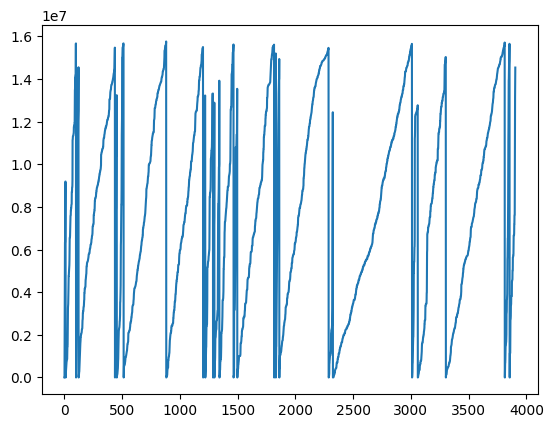

In [13]:
transactions_DT[transactions_DT.user_id <= 100]['time_diff'].plot()
print('Users:', transactions_DT['user_id'].nunique())
print('Time max:', transactions_DT['time_diff'].max())

In [31]:
def split(transactions, time_q, user_q):
    time_val = int(transactions['time_diff'].quantile(time_q))
    user_val = int(transactions['user_id'].quantile(user_q))
    print('user_id:', transactions['user_id'].min(), transactions['user_id'].max())
    print(f'user_id: quartile - {user_q}, value - {user_val}')
    print('time_diff:', transactions['time_diff'].min(), transactions['time_diff'].max())
    print(f'time_diff: quartile - {time_q}, value - {time_val}')
    
    select_train = (transactions['time_diff'] <= time_val) & (transactions['user_id'] <= user_val)
    select_test = (transactions['time_diff'] > time_val) & (transactions['user_id'] > user_val)
    transactions_train = transactions[select_train]
    transactions_test = transactions[select_test]
    
    all_n, train_n, test_n = transactions.shape[0], transactions_train.shape[0], transactions_test.shape[0]
    print('transactions:', all_n)
    print('train:', train_n, train_n/all_n)
    print('test:', test_n, test_n/all_n)
    print('proportion:', train_n/test_n)
    return transactions_train, transactions_test

In [32]:
train_transactions, test_transactions = split(transactions_DT, args.time_quantile, args.user_quantile)

user_id: 3 562740
user_id: quartile - 0.9, value - 481871
time_diff: 0 15767876
time_diff: quartile - 0.9, value - 13898545
transactions: 13075023
train: 10581102 0.8092606796944066
test: 121063 0.009259104171365511
proportion: 87.40161733973221


In [35]:
def check_split(train, test):
    print('users intersection:', np.intersect1d(train['user_id'].to_numpy(), test['user_id'].to_numpy()))
    print('time intersection:', np.intersect1d(train['time_diff'].to_numpy(), test['time_diff'].to_numpy()))
          
check_split(train_transactions, test_transactions)

users intersection: []
time intersection: []


In [37]:
transactions_DT.to_csv(args.output.replace('%', 'all'), index = False)
train_transactions.to_csv(args.output.replace('%', 'train'), index = False)
test_transactions.to_csv(args.output.replace('%', 'test'), index = False)

In [38]:
!head transactions_dt_all.csv
!head transactions_dt_train.csv
!head transactions_dt_test.csv

user_id,mcc_code,currency_rk,transaction_amt,time_diff
3,3,1,-183.88395690918,0
3,3,1,-3206.43701171875,2817
3,16,1,-153866.890625,1651223
3,56,1,-15144.6015625,3484376
3,0,1,5297.90869140625,3737158
3,0,1,534.363098144531,6338573
3,0,1,4549.455078125,6338882
3,0,1,37991.9296875,7886245
3,0,1,28335.61328125,8411225
user_id,mcc_code,currency_rk,transaction_amt,time_diff
3,3,1,-183.88395690918,0
3,3,1,-3206.43701171875,2817
3,16,1,-153866.890625,1651223
3,56,1,-15144.6015625,3484376
3,0,1,5297.90869140625,3737158
3,0,1,534.363098144531,6338573
3,0,1,4549.455078125,6338882
3,0,1,37991.9296875,7886245
3,0,1,28335.61328125,8411225
user_id,mcc_code,currency_rk,transaction_amt,time_diff
481881,11,1,-32.8296432495117,13911818
481881,11,1,-38.3924026489258,13968559
481881,11,1,-38.2651023864746,14001330
481881,11,1,-38.4550018310547,14003747
481881,11,1,-33.0201759338379,14085214
481881,4,1,-1128.57153320312,14111523
481881,11,1,-38.1655616760254,14305321
481881,1,1,-110.690567016602,14347185
4

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp transactions_dt.csv drive/MyDrive/TimeGradProject/

In [ ]:
# !head transactions_dt.csv

user_id,mcc_code,currency_rk,transaction_amt,time_diff
3,3,1,-183.88395690918,0.0
3,3,1,-3206.43701171875,2817.0
3,16,1,-153866.890625,1651223.0
3,56,1,-15144.6015625,3484376.0
3,0,1,5297.90869140625,3737158.0
3,0,1,534.363098144531,6338573.0
3,0,1,4549.455078125,6338882.0
3,0,1,37991.9296875,7886245.0
3,0,1,28335.61328125,8411225.0
